In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage.filters import rank
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation
from skimage import restoration

from sklearn import preprocessing

from scipy import ndimage as ndi

## I/O

In [5]:
# img_file = io.imread('13G_Diplo_0_05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new_0612.tif'
img_file = '13G_Srosetta_0_05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new_24.tif'
# img_file = 'D44_Diplo_0_05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new_051.tif'
img_name = img_file.split('.')[0]

img_raw = io.imread(img_file)
print(img_raw.shape)

(8, 728, 968, 3)


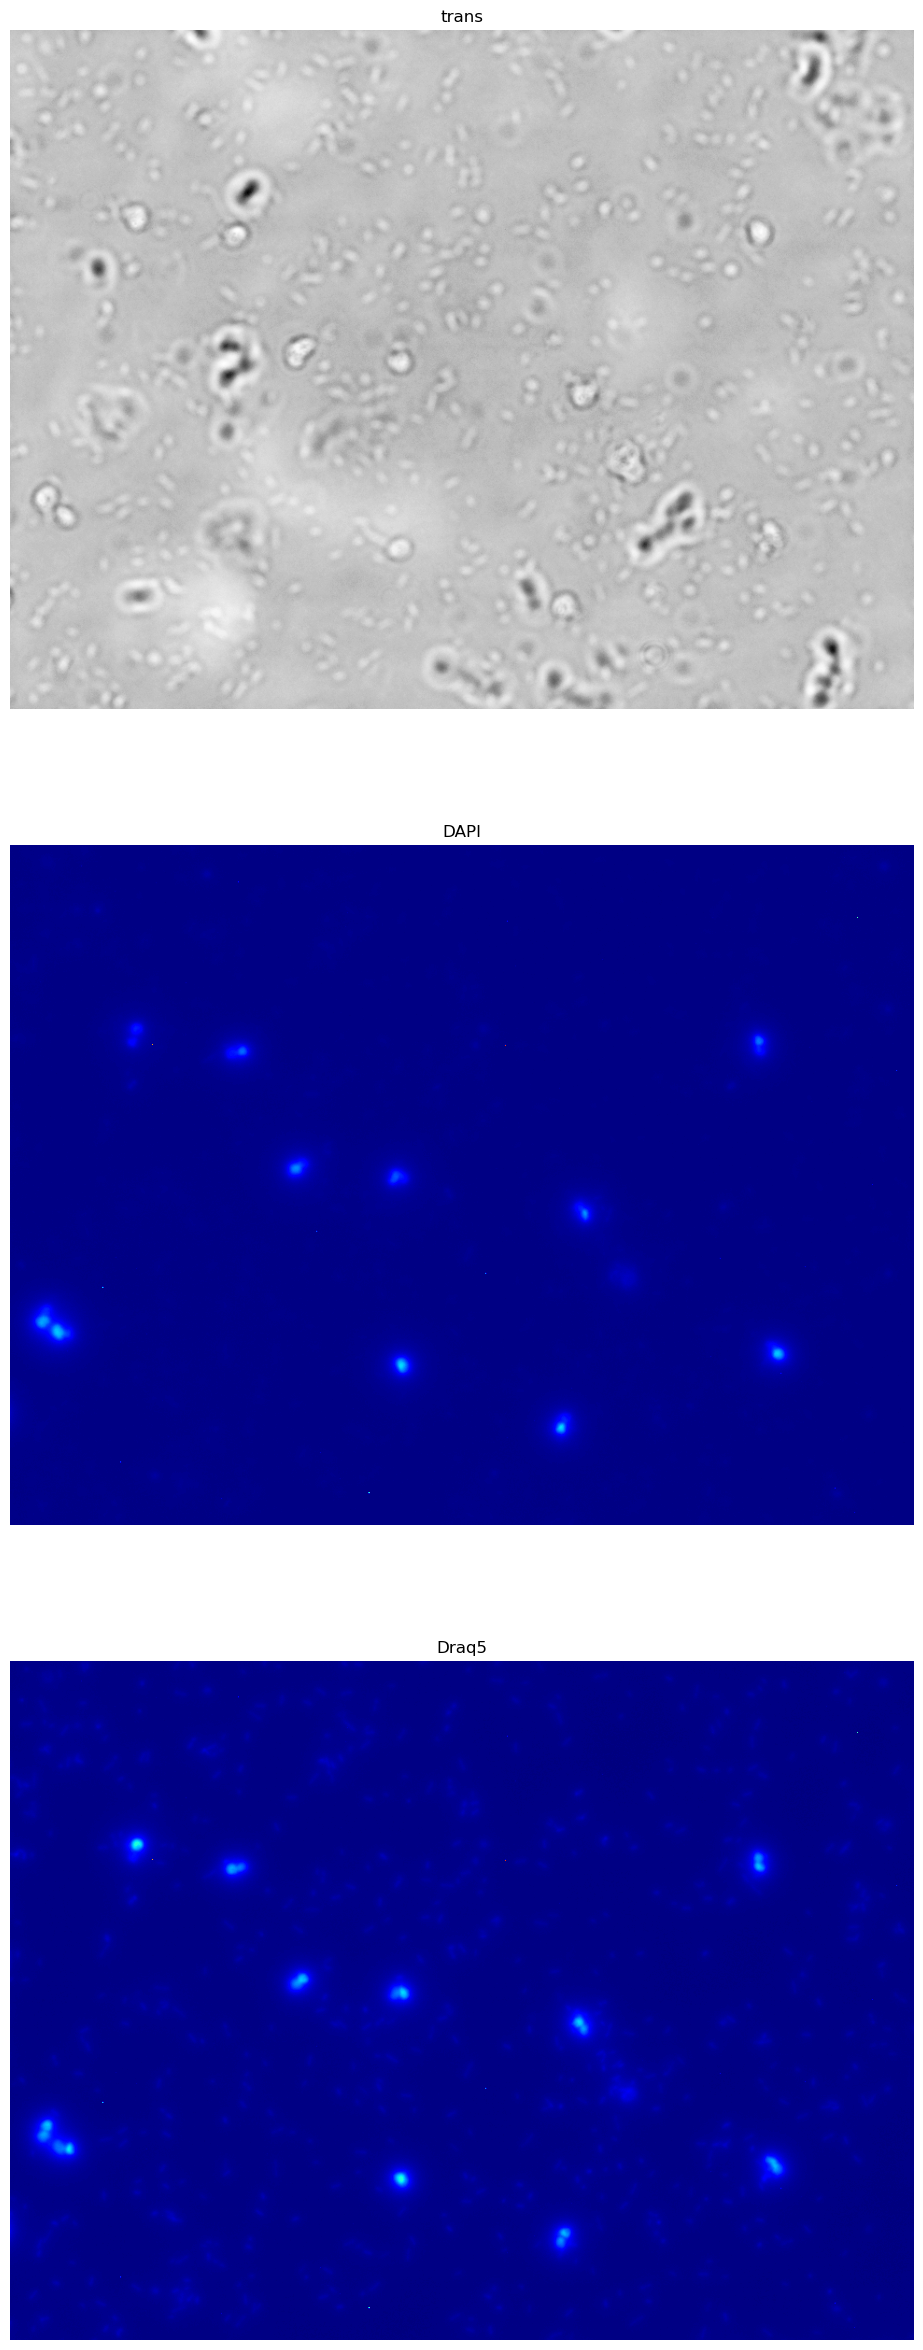

In [6]:
img_ch0 = img_raw[:,:,:,0]
img_ch1 = img_raw[:,:,:,1]
img_ch2 = img_raw[:,:,:,2]

img_trans = np.mean(img_ch0, axis=0)
img_dapi = np.sum(img_ch2, axis=0, dtype='int64')
img_draq = np.sum(img_ch1, axis=0, dtype='int64')


plt.figure(figsize=(30,30))

ax0 = plt.subplot(312)
ax0.imshow(img_dapi, cmap='jet')
ax0.set_title('DAPI')
ax0.axis('off')

ax1 = plt.subplot(311)
ax1.imshow(img_trans, cmap='Greys')
ax1.set_title('trans')
ax1.axis('off')

ax2 = plt.subplot(313)
ax2.imshow(img_draq, cmap='jet')
ax2.set_title('Draq5')
ax2.axis('off')

plt.show()

## Cells mask

/tmp/ipykernel_9036/4213340998.py:5: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))


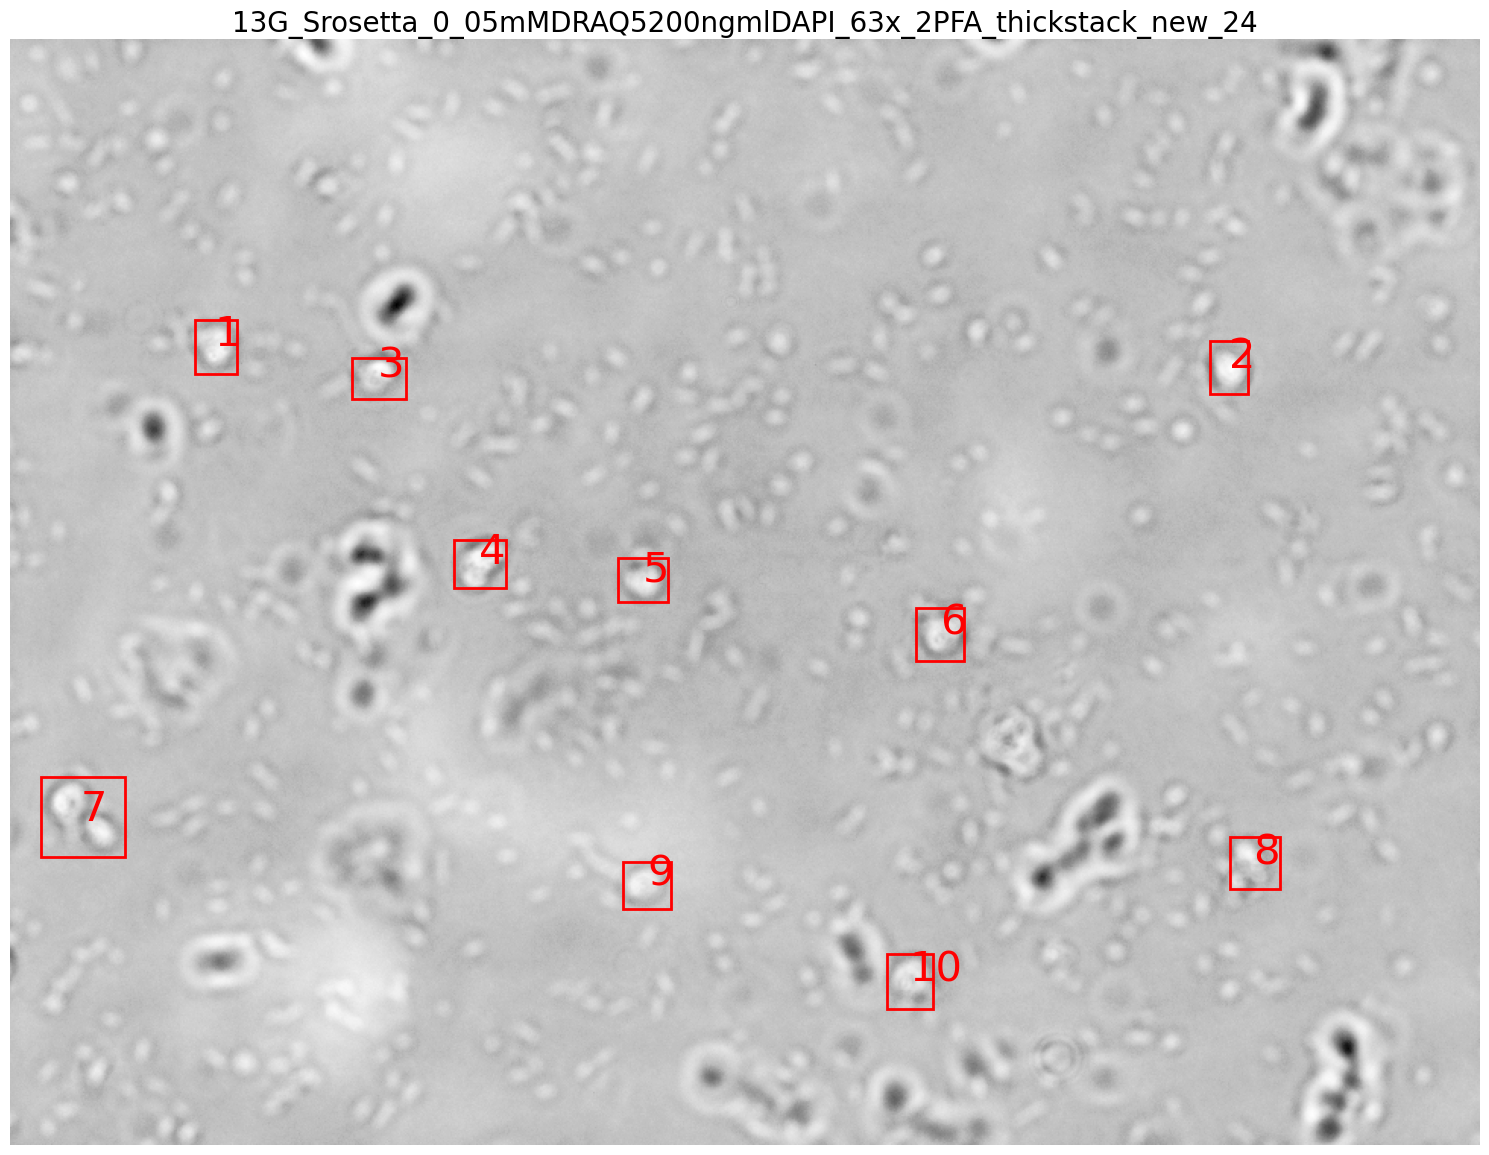

In [7]:
# masking by trans img
img_trans_filt = filters.gaussian(img_trans, sigma=2)

img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
mask = ndi.binary_fill_holes(mask)
mask = segmentation.clear_border(mask)

mask = morphology.erosion(mask, footprint=morphology.disk(5))
mask = morphology.dilation(mask, footprint=morphology.disk(4))

labels, labels_num = ndi.label(mask)

# debris filtering
ctrl_fluo_img = img_dapi + img_draq
ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
connected = sums > 0
debris_mask = connected[labels]

# final mask filtering
fin_trans_mask = np.copy(mask)
fin_trans_mask[~debris_mask] = 0  # debris rejection
# fin_trans_mask[ctrl_fluo_mask] = 1  # holes filling with DAPI+DRAQ mask
# fin_trans_mask = segmentation.clear_border(fin_trans_mask)  # borders cleaning
# fin_trans_mask = morphology.opening(fin_trans_mask, footprint=morphology.disk(5))  # rejection of DAPI+DRAW mask artifacts
# fin_trans_mask = ndi.binary_fill_holes(fin_trans_mask)

fin_fluo_mask = morphology.dilation(ctrl_fluo_mask, footprint=morphology.disk(4))
fin_fluo_mask = segmentation.clear_border(fin_fluo_mask)
fin_fluo_mask = morphology.opening(fin_fluo_mask, footprint=morphology.disk(6))  # rejection of DAPI+DRAW mask artifacts

cells_labels, cells_num = ndi.label(fin_fluo_mask)


# plt.figure(figsize=(20,20))

# ax1 = plt.subplot()
# ax1.imshow(img_trans, cmap='Greys')
# ax1.imshow(ma.masked_where(~fin_trans_mask, cells_labels), cmap='jet', alpha=.5)
# ax1.imshow(ma.masked_where(~fin_fluo_mask, fin_fluo_mask), cmap='Greys', alpha=.4)
# ax1.imshow(ma.masked_where(debris_mask, ~debris_mask), cmap='magma', alpha=.75)
# ax1.axis('off')
# ax1.set_title(f'DNA-containing elements selection ({cells_num} cells)\nwhite - DAPI+DRAQ regions, black - debris',
#               fontsize=30)

# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_trans, cmap='Greys')
ax.set_axis_off()
ax.set_title('Cells regions')

for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=30)

plt.title(img_name, fontsize=20)
plt.tight_layout()
plt.show()

## DEMO

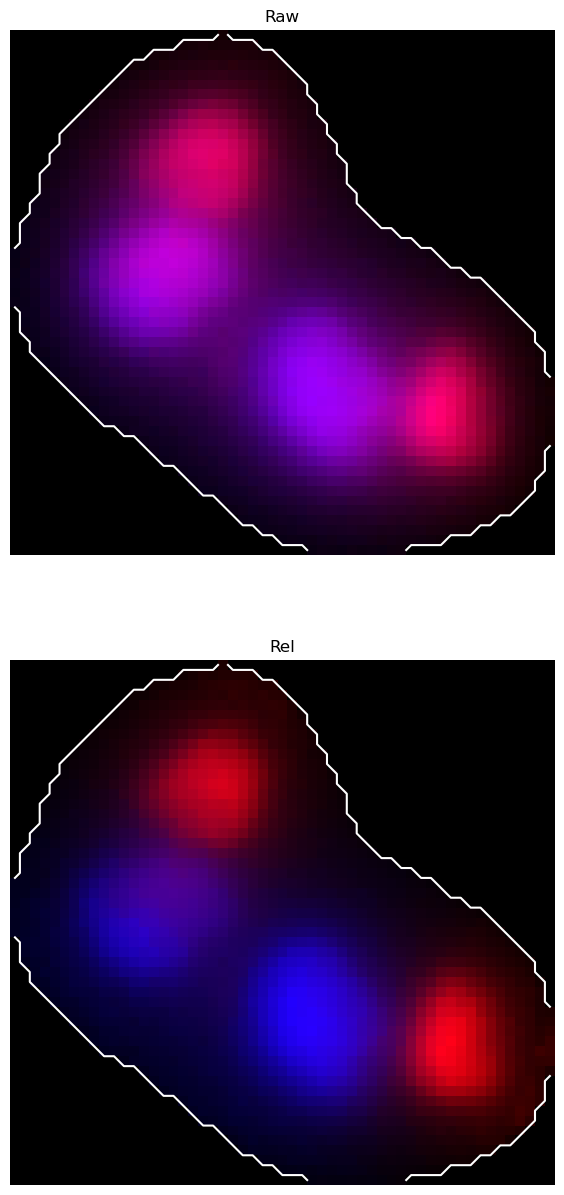

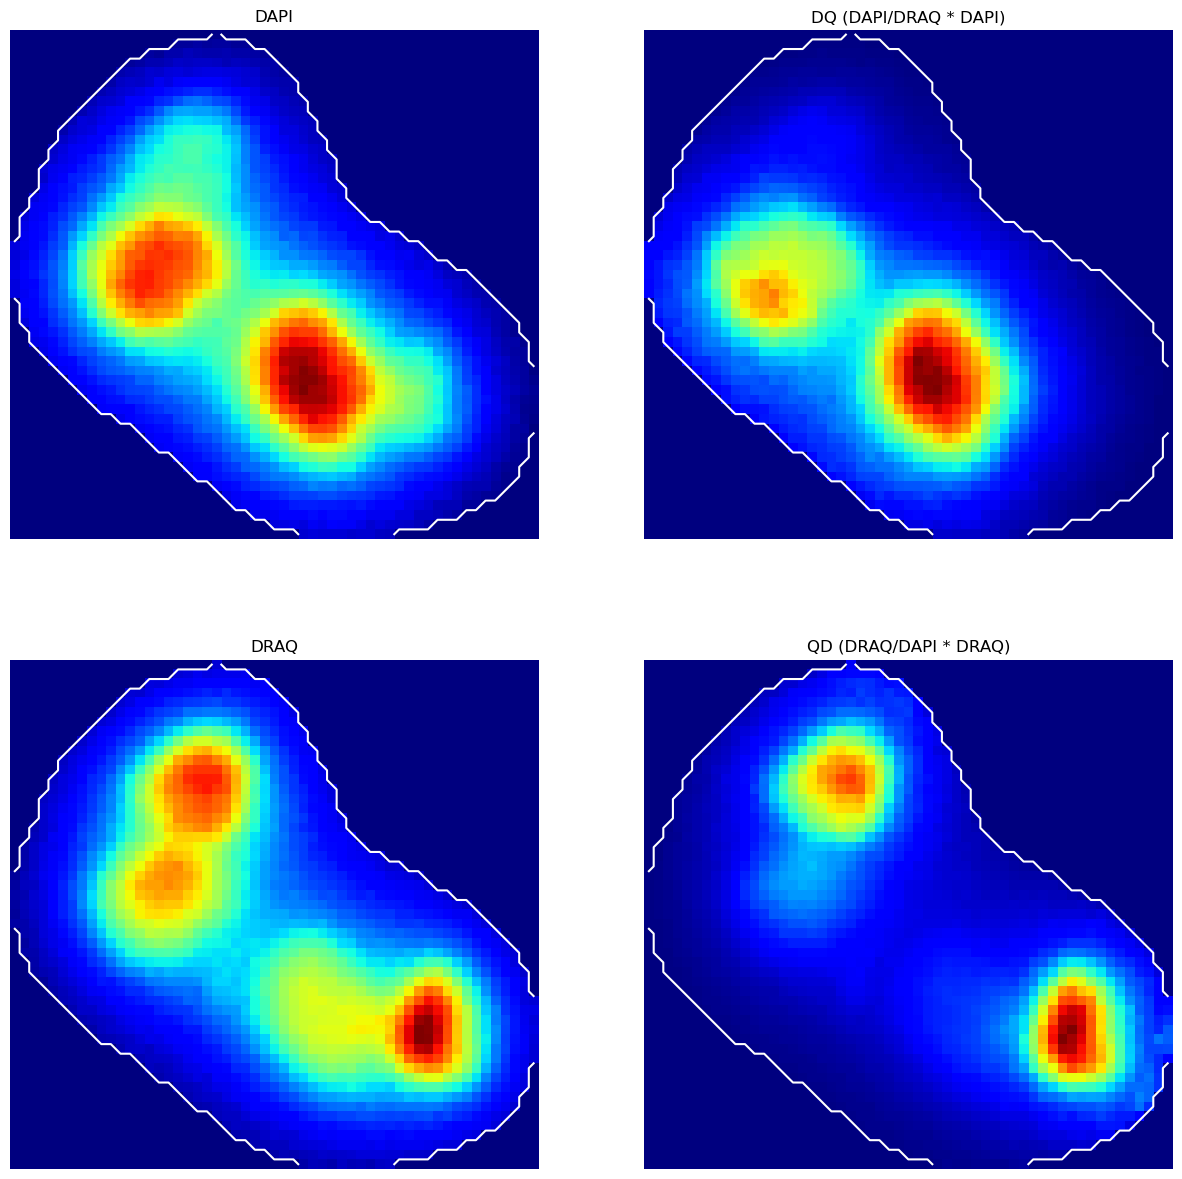

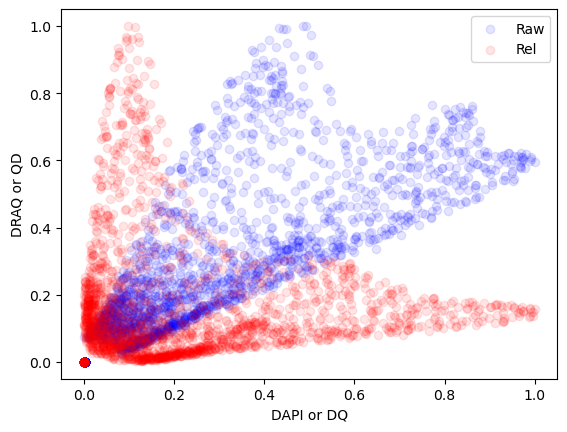

In [18]:
class OneCell():
    def __init__(self, cell_num:int, dapi_img:np.ndarray, draq_img:np.ndarray, trans_img:np.ndarray, cell_mask:np.ndarray):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask
        self.cell_contour = measure.find_contours(self.cell_mask, level=0.5)  # mask contour for ctrl images
        self.zeros = np.zeros_like(self.cell_mask)  # zeros image for green channel in RGB images

        self.trans_img = trans_img

        self.dapi_img = np.float32(dapi_img)
        self.dapi_img = self.dapi_img - np.mean(self.dapi_img, where=~self.cell_mask)  # background extraction
        self.dapi_img[~self.cell_mask] = np.mean(self.dapi_img, where=~self.cell_mask)  # extracellular px masking

        self.draq_img = np.float32(draq_img)
        self.draq_img = self.draq_img - np.mean(self.draq_img, where=~self.cell_mask)  # background extraction
        self.draq_img[~self.cell_mask] = np.mean(self.draq_img, where=~self.cell_mask)  # extracellular px masking

        self.scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), clip=True)  # naive 0-1 scaler, sensitive to outliers
        # self.scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(2.0, 98.0))

        self.dapi_norm = self.scaler.fit_transform(self.dapi_img.reshape(-1,1)).reshape(self.dapi_img.shape)
        self.draq_norm = self.scaler.fit_transform(self.draq_img.reshape(-1,1)).reshape(self.draq_img.shape)   
        self.raw_overlay = np.stack([self.draq_norm, self.zeros, self.dapi_norm], axis=-1)

        self.qd_rel = np.divide(self.draq_norm, self.dapi_norm, out=np.zeros_like(self.draq_norm), where=self.dapi_norm!=0)
        self.qd_rel = filters.median(self.qd_rel)
        self.qd = self.draq_img * self.qd_rel
        self.dq_rel = np.divide(self.dapi_norm, self.draq_norm, out=np.zeros_like(self.dapi_norm), where=self.draq_norm!=0)
        self.dq_rel = filters.median(self.dq_rel)
        self.dq = self.dapi_img * self.dq_rel

        self.qd_norm = self.scaler.fit_transform(self.qd.reshape(-1,1)).reshape(self.qd.shape)
        self.dq_norm = self.scaler.fit_transform(self.dq.reshape(-1,1)).reshape(self.dq.shape)
        self.rel_overlay = np.stack([self.qd_norm, self.zeros, self.dq_norm], axis=-1)


    def pic_3d(self):
        xx, yy = np.mgrid[0:self.cell_mask.shape[0], 0:self.cell_mask.shape[1]]

        import plotly.graph_objects as go
        from plotly.offline import iplot

        data = [go.Surface(x=xx,y=yy,z=self.draq_norm,
                        colorscale='Reds', opacity=0.65, showscale=False),
                go.Surface(x=xx,y=yy,z=self.dapi_norm,
                        colorscale='Blues', opacity=0.65, showscale=False)]
        iplot(data)


    def pic_grid(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(224)
        ax0.imshow(self.qd_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('QD (DRAQ/DAPI * DRAQ)')
        ax0.axis('off')

        ax2 = plt.subplot(223)
        ax2.imshow(self.draq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('DRAQ')
        ax2.axis('off')

        ax1 = plt.subplot(222)
        ax1.imshow(self.dq_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax1.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax1.set_title('DQ (DAPI/DRAQ * DAPI)')
        ax1.axis('off')

        ax3 = plt.subplot(221)
        ax3.imshow(self.dapi_norm, cmap='jet')
        for ce_c in self.cell_contour:
            ax3.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax3.set_title('DAPI')
        ax3.axis('off')

        plt.show()


    def pic_overlay(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(211)
        ax0.imshow(self.raw_overlay)
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('Raw')
        ax0.axis('off')

        ax2 = plt.subplot(212)
        ax2.imshow(self.rel_overlay)
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('Rel')
        ax2.axis('off')

    
    def pic_px_plot(self):
        plt.scatter(self.dapi_norm.ravel(), self.draq_norm.ravel(),
            color='b', alpha=.1, label='Raw')
        plt.scatter(self.dq_norm.ravel(), self.qd_norm.ravel(),
                    color='r', alpha=.1, label='Rel')
        plt.xlabel('DAPI or DQ')
        plt.ylabel('DRAQ or QD')
        plt.legend()
        plt.show()


for region in measure.regionprops(cells_labels):
    if region.label == 7:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
        demo_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_fluo_mask[minr:maxr, minc:maxc])
        
demo_cell.pic_overlay()
demo_cell.pic_grid()
demo_cell.pic_px_plot()

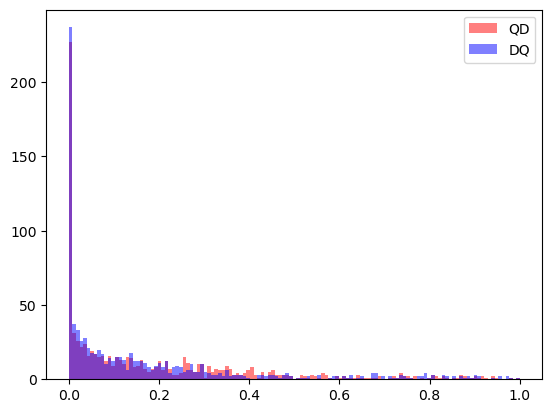

In [13]:
plt.hist(demo_cell.qd_norm.ravel(), bins=127, range=(0,1), color='r', alpha=.5, label='QD')
plt.hist(demo_cell.dq_norm.ravel(), bins=127, range=(0,1), color='b', alpha=.5, label='DQ')
plt.legend()
plt.show()

## Cells separation

#### Class for individual cells (OLD VERSION)

In [ ]:
class OneCellOld():
    def __init__(self, cell_num, dapi_img, dapi_sum_img, draq_img, draq_sum_img, trans_img, cell_mask, **kwargs):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask

        self.dapi_img = dapi_img
        self.draq_img = draq_img
        self.trans_img = trans_img

        self.dapi_sum_img = dapi_sum_img
        self.draq_sum_img = draq_sum_img

        self.dapi_norm = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        self.rgb_overlay = np.stack([self.draq_norm, zeros, self.dapi_norm], axis=-1)  # red - DAPI, green - Draq5

        # nDNA/kDNA masking
        self.k_mask, self.n_mask, self.kn_label, self.kn_mask, self.mask_qual = self.create_kineto_mask(dapi_norm=self.dapi_norm,
                                                                                                        draq_norm=self.draq_norm,
                                                                                                        **kwargs)
         
    
    @staticmethod
    def create_kineto_mask(dapi_norm, draq_norm, filter_n=False, show_debug_img=False):
        diff_img = dapi_norm - draq_norm
        sum_img = draq_norm + dapi_norm

        # kDNA masking
        k_mask_raw = diff_img > filters.threshold_otsu(diff_img)
        k_mask = morphology.opening(k_mask_raw, morphology.disk(1))

        # nDNA masking
        n_mask_raw = sum_img > filters.threshold_otsu(sum_img)
        n_mask_raw[k_mask] = 0
        if filter_n:
            n_mask = morphology.erosion(n_mask_raw, morphology.disk(1))
        else:
            n_mask = n_mask_raw

        mask_q = ''
        if np.sum(k_mask) > np.size(n_mask) * 0.5:
            mask_q = '(bad mask)'

        kn_label = np.zeros_like(dapi_norm)
        kn_label[k_mask] = 1
        kn_label[n_mask] = 2

        kn_mask = kn_label != 0

        if show_debug_img:
            plt.figure(figsize=(15,15))

            ax0 = plt.subplot(231)
            ax0.imshow(diff_img)
            ax0.set_title('DAPI-Draw5  (diff img)')
            ax0.axis('off')

            ax5 = plt.subplot(232)
            ax5.imshow(sum_img)
            ax5.set_title('DAPI+Draw5  (summ img)')
            ax5.axis('off')

            ax1 = plt.subplot(233)
            ax1.imshow(k_mask_raw)
            ax1.set_title('k mask raw')
            ax1.axis('off')

            ax2 = plt.subplot(234)
            ax2.imshow(k_mask)
            ax2.set_title('k mask')
            ax2.axis('off')

            ax3 = plt.subplot(235)
            ax3.imshow(n_mask_raw)
            ax3.set_title('n mask raw')
            ax3.axis('off')

            ax3 = plt.subplot(236)
            ax3.imshow(n_mask)
            ax3.set_title('n mask')
            ax3.axis('off')

            plt.tight_layout()
            plt.show()

        return k_mask, n_mask, kn_label, kn_mask, mask_q


    def create_kineto_mask_old(self):
        """ previous detection method
        
        """ 
        

        diff = self.dapi_norm - self.draq_norm

        self.k_mask_raw = diff > filters.threshold_otsu(diff)

        diff_masked = ma.masked_where(~self.k_mask_raw, diff)

        self.k_mask = diff > filters.threshold_otsu(diff_masked.compressed())

        self.n_mask = self.draq_norm > filters.threshold_otsu(self.draq_norm)

        if np.sum(self.k_mask) > np.size(diff) * 0.5:
            print("Bad mask")

        self.kn_label = np.zeros_like(self.dapi_img)
        self.kn_label[self.k_mask] = 1
        self.kn_label[self.n_mask] = 2

        self.kn_mask = self.kn_label != 0

        plt.figure(figsize=(10, 10))
        plt.imshow(self.trans_img, cmap='Greys')
        plt.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        plt.title('Red-nucleus')
        plt.axis('off')

        plt.show()
        
        
    def ctrl_masks_img(self):
        plt.figure(figsize=(15,5))

        ax0 = plt.subplot(131)
        ax0.imshow(self.trans_img, cmap='Greys')
        ax0.imshow(ma.masked_where(~self.cell_mask, self.cell_mask), cmap='jet', alpha=.3)
        ax0.set_title('Trans ch. with cell mask overlay')
        ax0.axis('off')

        ax1 = plt.subplot(132)
        ax1.imshow(self.rgb_overlay)
        ax1.set_title('DAPI-blue, Draq5-red')
        ax1.axis('off')

        ax2 = plt.subplot(133)
        ax2.imshow(self.trans_img, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        ax2.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        ax2.set_title('Red-nDNA, blue-kDNA')
        ax2.axis('off')

        plt.suptitle(f'Cell {self.cell_num} {self.mask_qual}')
        plt.tight_layout()
        plt.show()


    def calc_cell_parameters(self):
        cell_df = pd.DataFrame({'num':self.cell_num,
                                'species':self.cell_species,
                                'cell_area':np.sum(self.cell_mask),
                                'kDNA_int':np.sum(self.dapi_sum_img, where=self.k_mask),
                                'kDNA_area':np.sum(self.k_mask),
                                'nDNA_int':np.sum(self.draq_sum_img, where=self.n_mask),
                                'nDNA_area':np.sum(self.n_mask)},
                                index=[0])

        return cell_df


### Loop over cells

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_trans, cmap='Greys')
ax.set_axis_off()
ax.set_title('Cells regions')

cells_list = []
for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)

    cells_list.append(OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            dapi_sum_img=img_dapi_sum[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            draq_sum_img=img_draq_sum[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_mask[minr:maxr, minc:maxc],
                            filter_n=False,
                            show_debug_img=False))

plt.tight_layout()
plt.show()

for cell in cells_list:
    cell.ctrl_masks_img()


## Output

### Filtering and species sorting

In [ ]:
species_dict = {1:'A',      # only cells presented in this dict by numbers will be added to good cells list
                3:'A',
                4:'B',
                5:'C'}

good_cells_list = []
for cell in cells_list:
    if cell.cell_num in species_dict.keys():
        cell.cell_species = species_dict[cell.cell_num]
        good_cells_list.append(cell)


### Data frame

In [ ]:
output_df = pd.DataFrame(columns=['num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

for cell in good_cells_list:
    cell_df = cell.calc_cell_parameters()

    output_df = pd.concat([output_df, cell_df],
                           ignore_index=True)

In [ ]:
output_df